In [39]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sympy import symbols, cos, sin
from sympy.plotting import plot_parametric
from math import sin,cos
import io
import cv2
import pykalman

# Лабораторная работа 1.5
В файле ’eyetracking.npz’ содержатся записи траекторий взгляда нескольких человек
при рассматривании различных изображений . На основе данных для фиксированного человека (subject) и фиксированного изображения (stimuli) с помощью EM-алгоритма обучена линейную модель пространства состояний. Затем на основе обученной модели сглажена траектория для другого набора данных с помощью процедуры Рауха-Тунга-Стрибела.

#  Байесовское сглаживание
$$ p(x_{k+1}|y_1..y_k) = \int p(x_{k+1}|x_k)p(x_k,y_1..y_k) dx_k $$
$$ p(x_k|y_1..y_T) = p(x_k|y_1..y_k) \int \frac{p(x_{k+1}|x_k)p(x_{k+1}|y_1..y_T)}{p(x_{k+1}|y_1..y_k)} dx_{k+1} $$

In [33]:
def print_img(img):
    plt.imshow(img)
    plt.show()

In [28]:
data_fname = '/home/qwe/Desktop/анализ сигналов/data files/eyetracking.npz'
with np.load(data_fname, allow_pickle=True) as dobj:
    data = dict(**dobj)
images = [plt.imread(io.BytesIO(stim), format='JPG')
    for stim in data['stimuli']]
subjects = data['subjects']
    

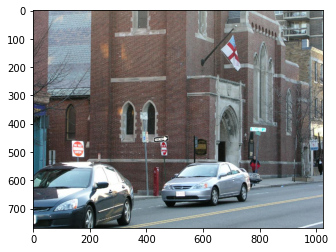

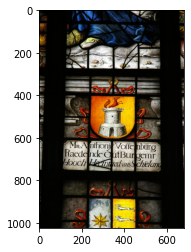

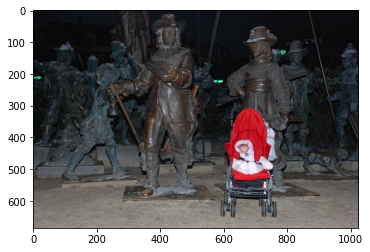

In [34]:
for img in images:
    print_img(img)

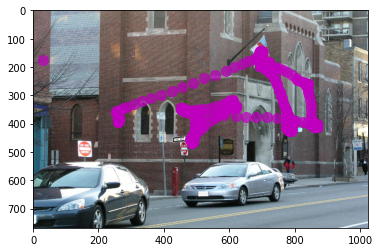

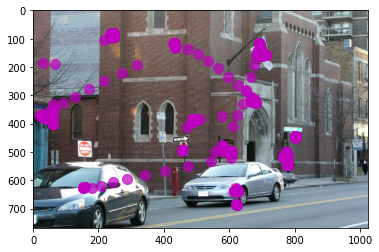

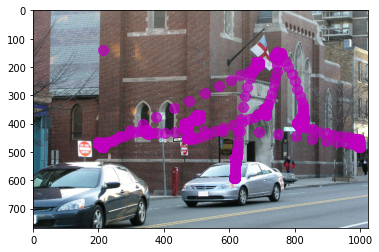

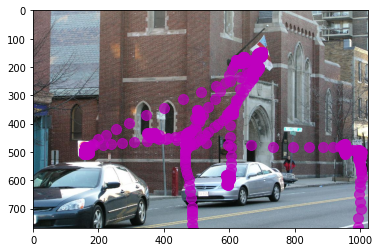

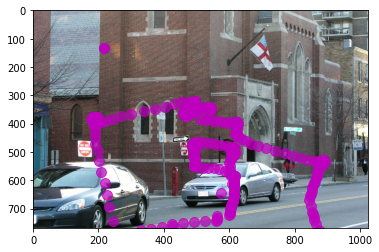

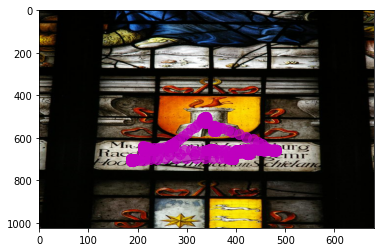

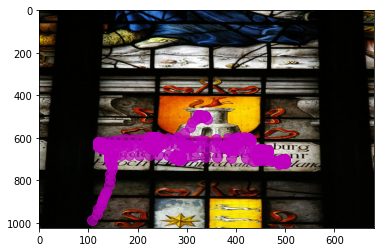

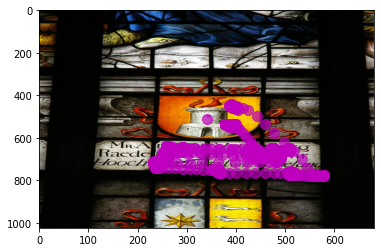

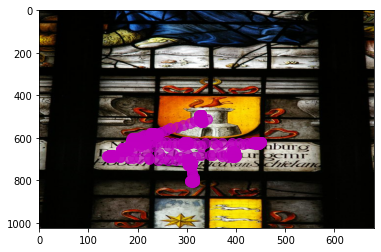

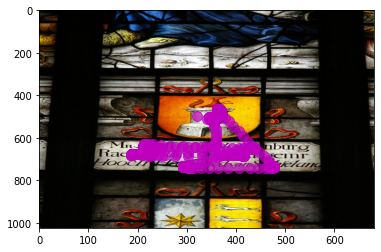

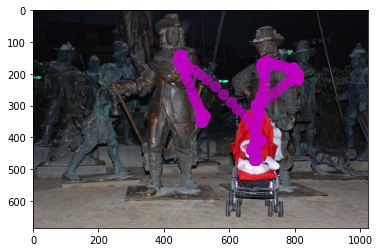

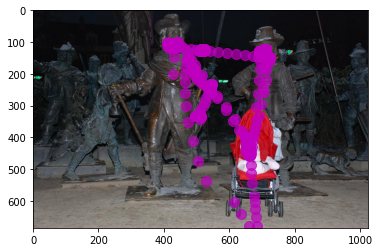

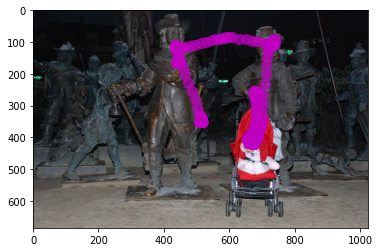

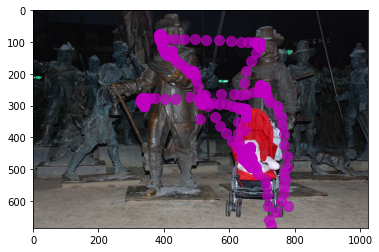

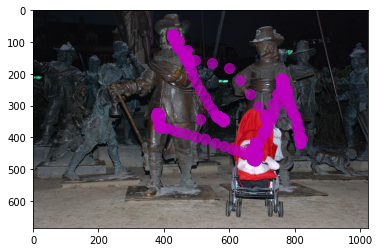

In [36]:
for i in range(len(images)):
    for j in range(len(subjects)):
        subject = subjects[j]
        data = subject[i]
        img = images[i]

        fig, ax = plt.subplots()
        ax.imshow(img, aspect='auto')
        ax.scatter(data[:, 0], data[:, 1], c='m', s=100, alpha=0.7)
        ax.set(xlim=(0, img.shape[1]), ylim=(img.shape[0], 0))

In [40]:
np.random.seed(1)
# размерности пространства состояния и наблюдения
n_dim_obs = 2
n_dim_state = 2


kf = pykalman.KalmanFilter(
  n_dim_state=n_dim_state,
  n_dim_obs=n_dim_obs,
  em_vars=['transition_matrices', 'transition_covariance',
           'observation_matrices', 'observation_covariance',
           'initial_state_mean','initial_state_covariance']
)

In [41]:
# выбираем индекс изображения и пути для обучения
subject_id = 1
image_id = 2
data = subjects[subject_id][image_id]

#Получаем параметры из EM алгоритма
kf.em(data)

print(f'A=\n{kf.transition_matrices}')
print(f'Q =\n{kf.transition_covariance}')
print(f'H =\n{kf.observation_matrices}')
print(f'R =\n{kf.observation_covariance}')
print(f'm0 =\n{kf.initial_state_mean}')
print(f'p0 =\n{kf.initial_state_covariance}')

A=
[[ 1.00381468 -0.00872859]
 [ 0.00468072  0.98961761]]
Q =
[[302.88599617 231.24162619]
 [231.24162619 394.34933296]]
H =
[[ 0.9957901   0.01952907]
 [-0.00644041  1.02146494]]
R =
[[187.83142411 131.70936203]
 [131.70936203 104.44403722]]
m0 =
[322.42876462 209.97575323]
p0 =
[[0.34250229 0.04216089]
 [0.04216089 0.31958926]]


In [43]:
# функции отрисовки 
def plot_gaze_data(data, img=None, ax=None):
    # overlay gaze on stimulus
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    xlim = None
    ylim = None
    if img is not None:
        ax.imshow(img, aspect='auto')
        ylim = (img.shape[0], 0)
        xlim = (0, img.shape[1])

    ax.scatter(data[:, 0], data[:, 1], c='m', s=100, alpha=0.7)
    ax.set(xlim=xlim, ylim=ylim)

    return ax


def plot_kf_state(kf, data, ax):
    mu_0 = np.ones(kf.n_dim_state)
    mu_0[:data.shape[1]] = data[0]
    kf.initial_state_mean = mu_0

    mu, sigma = kf.smooth(data)
    ax.plot(mu[:, 0], mu[:, 1], 'limegreen', linewidth=3, zorder=1)
    ax.scatter(mu[0, 0], mu[0, 1], c='orange', marker='>', s=200, zorder=2)
    ax.scatter(mu[-1, 0], mu[-1, 1], c='orange', marker='s', s=200, zorder=2)

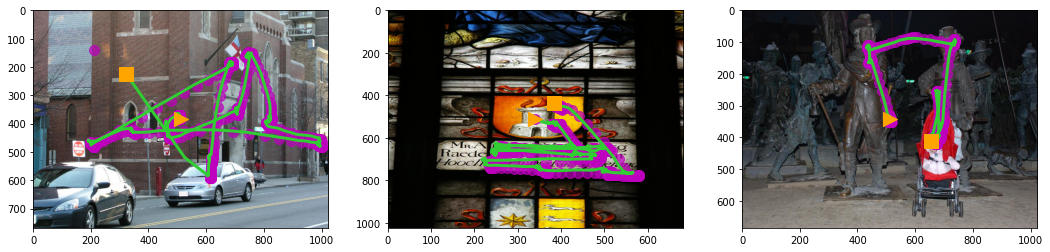

In [45]:
# иллюстрация работы алгоритма
subject_id = 2
subject = subjects[subject_id]
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))
for data, img, ax in zip(subject, images, axes):
    ax = plot_gaze_data(data, img=img, ax=ax)
    plot_kf_state(kf, data, ax)